In [1]:
from typing import Union, List, Optional
from torchvision import transforms
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import zipfile
import torch
import cv2
import os

Files are located in /kaggle/working/clothes
Files ['cloth24192_dress.jpg', 'cloth11208_shoe.jpg', 'cloth5458_shorts.jpg', 'cloth24879_pants.jpg', 'cloth22999_shorts.jpg', 'cloth6247_shoe.jpg', 'cloth9032_pants.jpg', 'cloth37_shoe.jpg', 'cloth8687_shorts.jpg', 'cloth10624_shoe.jpg']


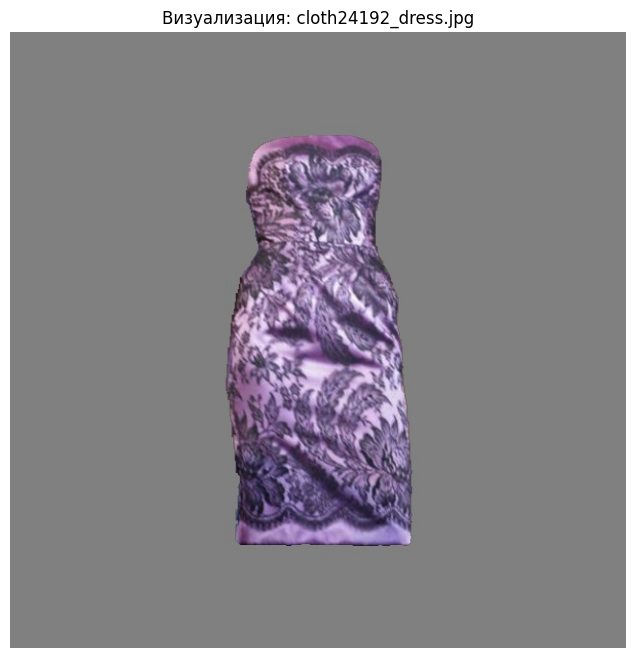

In [2]:
zip_path = '/kaggle/input/notebook7d00437634/clothes.zip'

extract_dir = '/kaggle/working/clothes'
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    print(f'Files are located in {extract_dir}')

extracted_files = os.listdir(extract_dir)
print("Files", extracted_files[:10])


img_path = os.path.join(extract_dir, extracted_files[0])
img = Image.open(img_path)
    
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f'Визуализация: {extracted_files[0]}')
plt.show()

In [3]:
base = "/kaggle/working/clothes"
clothes = [f"{base}/{file}" for file in extracted_files]
clothes[:5]

['/kaggle/working/clothes/cloth24192_dress.jpg',
 '/kaggle/working/clothes/cloth11208_shoe.jpg',
 '/kaggle/working/clothes/cloth5458_shorts.jpg',
 '/kaggle/working/clothes/cloth24879_pants.jpg',
 '/kaggle/working/clothes/cloth22999_shorts.jpg']

In [4]:
class DinoV2ImageEncoder:
    """
    A class for encoding images into embeddings
    using models from the DINOv2 family.

    This class loads a specified DINOv2 model and its corresponding
    image transformations. It can process both single images and batches of images.

    Attributes:
        device (torch.device): The device (CPU or CUDA) on which the model is running.
        model (torch.nn.Module): The loaded DINOv2 model.
        transform (transforms.Compose): The image transformation pipeline.
    """

    def __init__(self, model_name: str = 'dinov2_vitb14', device: Optional[str] = None):
        """
        Initializes the image encoder.

        Args:
            model_name (str): The name of the DINOv2 model to load.
                Available options include: 'dinov2_vits14', 'dinov2_vitb14',
                'dinov2_vitl14', 'dinov2_vitg14'.
            device (Optional[str]): The device to run the model on ('cuda', 'cpu').
                If None, it will auto-detect CUDA availability and use it,
                otherwise it will fall back to CPU.
        """
        print("Initializing DinoV2ImageEncoder...")

        self.device = self._get_device(device)
        print(f"Using device: {self.device}")

        print(f"Loading model '{model_name}'...")
        self.model = torch.hub.load('facebookresearch/dinov2', model_name)
        self.model.to(self.device)
        self.model.eval()  # Set the model to evaluation mode
        print("Model loaded successfully.")

        # Standard transformations for ViT/DINOv2 models
        self.transform = transforms.Compose([
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

    def _get_device(self, device: Optional[str]) -> torch.device:
        """Determines the computation device."""
        if device and torch.cuda.is_available() and device.lower() == 'cuda':
            return torch.device("cuda")
        elif device and device.lower() == 'cpu':
             return torch.device("cpu")
        
        # Auto-select
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def _load_and_preprocess_image(self, image_input: Union[str, Image.Image]) -> torch.Tensor:
        """
        Loads and preprocesses a single image.

        Args:
            image_input (Union[str, Image.Image]): The path to the image file, a URL, or a PIL.Image object.

        Returns:
            torch.Tensor: The preprocessed image tensor.
        """
        if isinstance(image_input, str):
            image = Image.open(image_input)
        image = image.convert('RGB')

        return self.transform(image)

    def encode(self, 
             image_inputs: Union[str, Image.Image, List[Union[str, Image.Image]]], 
             batch_size: int = 64) -> np.ndarray:
        """
        Encodes a single image or a batch of images into embeddings using mini-batching.

        Args:
            image_inputs (Union[str, Image.Image, List[Union[str, Image.Image]]]):
                A single image (as a path, URL, or PIL.Image) or a list of images.
            batch_size (int): The number of images to process in a single mini-batch.

        Returns:
            np.ndarray:
                A NumPy array containing the embeddings.
                - For a single image, the shape is (embedding_dim,).
                - For a list of images, the shape is (num_images, embedding_dim).
        """
        if not isinstance(image_inputs, list):
            image_inputs = [image_inputs]
            is_single_image = True
        else:
            is_single_image = False
            
        all_embeddings = []

        for i in range(0, len(image_inputs), batch_size):
            batch_inputs = image_inputs[i:i + batch_size]

            image_tensors = [self._load_and_preprocess_image(img) for img in batch_inputs]
            batch_tensor = torch.stack(image_tensors).to(self.device)

            with torch.no_grad():
                embeddings = self.model(batch_tensor)
                
                all_embeddings.append(embeddings.cpu().numpy())

        if not all_embeddings:
            return np.array([])

        final_embeddings = np.vstack(all_embeddings)
        
        if is_single_image:
            return final_embeddings.squeeze(0)
        else:
            return final_embeddings


In [5]:
def save_cloth_embeddings(text_file_path: str, clothes: List[str], embeddings: List[str]):
    with open(text_file_path, "a", encoding='utf-8') as file:
        for idx in range(len(clothes)):
            cloth_str_embeddings = ' '.join(map(str, embeddings[idx].tolist()))
            file.write(f"{clothes[idx]} {cloth_str_embeddings}\n")

---

**Encode clothes with large DinoV2 model**

In [6]:
embedder_large = DinoV2ImageEncoder("dinov2_vitl14")

Initializing DinoV2ImageEncoder...
Using device: cuda
Loading model 'dinov2_vitl14'...


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:04<00:00, 299MB/s]


Model loaded successfully.


In [7]:
global_batch = 640
output_file = "/kaggle/working/dino_large_embeddings.txt"
# clear file
with open(output_file, "w", encoding='utf-8') as file:
    file.write('')
# process clothes by batches
for start_idx in range(0, len(clothes), global_batch):
    clothes_batch = clothes[start_idx:start_idx+global_batch]
    clothes_names_batch = extracted_files[start_idx:start_idx+global_batch]
    embeddings_batch = embedder_large.encode(clothes_batch)
    save_cloth_embeddings(output_file, clothes_names_batch, embeddings_batch)
    print(f"{start_idx+global_batch} clothes are encoded and saved!")

640 clothes are encoded and saved!
1280 clothes are encoded and saved!
1920 clothes are encoded and saved!
2560 clothes are encoded and saved!
3200 clothes are encoded and saved!
3840 clothes are encoded and saved!
4480 clothes are encoded and saved!
5120 clothes are encoded and saved!
5760 clothes are encoded and saved!
6400 clothes are encoded and saved!
7040 clothes are encoded and saved!
7680 clothes are encoded and saved!
8320 clothes are encoded and saved!
8960 clothes are encoded and saved!
9600 clothes are encoded and saved!
10240 clothes are encoded and saved!
10880 clothes are encoded and saved!
11520 clothes are encoded and saved!
12160 clothes are encoded and saved!
12800 clothes are encoded and saved!
13440 clothes are encoded and saved!
14080 clothes are encoded and saved!
14720 clothes are encoded and saved!
15360 clothes are encoded and saved!
16000 clothes are encoded and saved!
16640 clothes are encoded and saved!
17280 clothes are encoded and saved!
17920 clothes are

---

**Encode clothes with base DinoV2 model**

In [8]:
embedder_base = DinoV2ImageEncoder("dinov2_vitb14")

Initializing DinoV2ImageEncoder...
Using device: cuda
Loading model 'dinov2_vitb14'...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:01<00:00, 251MB/s]


Model loaded successfully.


In [9]:
global_batch = 1280
output_file = "/kaggle/working/dino_base_embeddings.txt"
# clear file
with open(output_file, "w", encoding='utf-8') as file:
    file.write('')
# process clothes by batches
for start_idx in range(0, len(clothes), global_batch):
    clothes_batch = clothes[start_idx:start_idx+global_batch]
    clothes_names_batch = extracted_files[start_idx:start_idx+global_batch]
    embeddings_batch = embedder_base.encode(clothes_batch)
    save_cloth_embeddings(output_file, clothes_names_batch, embeddings_batch)
    print(f"{start_idx+global_batch} clothes are encoded and saved!")

1280 clothes are encoded and saved!
2560 clothes are encoded and saved!
3840 clothes are encoded and saved!
5120 clothes are encoded and saved!
6400 clothes are encoded and saved!
7680 clothes are encoded and saved!
8960 clothes are encoded and saved!
10240 clothes are encoded and saved!
11520 clothes are encoded and saved!
12800 clothes are encoded and saved!
14080 clothes are encoded and saved!
15360 clothes are encoded and saved!
16640 clothes are encoded and saved!
17920 clothes are encoded and saved!
19200 clothes are encoded and saved!
20480 clothes are encoded and saved!
21760 clothes are encoded and saved!
23040 clothes are encoded and saved!
24320 clothes are encoded and saved!
25600 clothes are encoded and saved!
26880 clothes are encoded and saved!
28160 clothes are encoded and saved!
29440 clothes are encoded and saved!
30720 clothes are encoded and saved!
32000 clothes are encoded and saved!
33280 clothes are encoded and saved!
34560 clothes are encoded and saved!
35840 cl

---

**Encode clothes with small DinoV2 model**

In [10]:
embedder_small = DinoV2ImageEncoder("dinov2_vits14")

Initializing DinoV2ImageEncoder...
Using device: cuda
Loading model 'dinov2_vits14'...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 259MB/s]


Model loaded successfully.


In [11]:
global_batch = 1280
output_file = "/kaggle/working/dino_small_embeddings.txt"
# clear file
with open(output_file, "w", encoding='utf-8') as file:
    file.write('')
# process clothes by batches
for start_idx in range(0, len(clothes), global_batch):
    clothes_batch = clothes[start_idx:start_idx+global_batch]
    clothes_names_batch = extracted_files[start_idx:start_idx+global_batch]
    embeddings_batch = embedder_small.encode(clothes_batch)
    save_cloth_embeddings(output_file, clothes_names_batch, embeddings_batch)
    print(f"{start_idx+global_batch} clothes are encoded and saved!")

1280 clothes are encoded and saved!
2560 clothes are encoded and saved!
3840 clothes are encoded and saved!
5120 clothes are encoded and saved!
6400 clothes are encoded and saved!
7680 clothes are encoded and saved!
8960 clothes are encoded and saved!
10240 clothes are encoded and saved!
11520 clothes are encoded and saved!
12800 clothes are encoded and saved!
14080 clothes are encoded and saved!
15360 clothes are encoded and saved!
16640 clothes are encoded and saved!
17920 clothes are encoded and saved!
19200 clothes are encoded and saved!
20480 clothes are encoded and saved!
21760 clothes are encoded and saved!
23040 clothes are encoded and saved!
24320 clothes are encoded and saved!
25600 clothes are encoded and saved!
26880 clothes are encoded and saved!
28160 clothes are encoded and saved!
29440 clothes are encoded and saved!
30720 clothes are encoded and saved!
32000 clothes are encoded and saved!
33280 clothes are encoded and saved!
34560 clothes are encoded and saved!
35840 cl